# Giving names to nodes

In [1]:
%matplotlib inline
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pygsp as pg

# import our own functions
from our_functions import get_true_labels, find_components, find_largest_component, give_names_tonodes_dates_based
import random

In [2]:
A = np.load('adjacency.npy')

# get the largest component
A, size = find_largest_component(find_components(A))

n_nodes = size
n_edges = np.count_nonzero(A) / 2

# get terrorist names for each node
names, A, name_dict = give_names_tonodes_dates_based(A)

# get relation label for each node
labels = get_true_labels(A)

In [3]:
name_dict

{'UmarBaziyani': {0, 19, 20, 428, 432, 441, 443},
 'Saif_Aldin_Mustafa_Nuaimi': {0, 1, 2, 3, 425, 426, 427},
 'Muhammad_Daham_Abu_Hamadi': {1, 7, 16, 18, 19, 429, 445},
 'Abu_Karrar': {2, 5, 16, 17, 433, 441, 442},
 'Abu_Jalal_Iraqi': {3, 6, 17, 18, 434, 443, 444},
 'Zarqawi': {4, 7, 8, 235, 301, 425, 432, 433, 434, 724, 726},
 'Abu_Obaida_Kubaisi': {4, 5, 6, 426, 428, 429, 430},
 'Abdul_Qadir_Ashur_Jaburi': {8, 20, 427, 430, 442, 444, 445},
 '/2005/09/08/05:06:43': {9,
  56,
  77,
  82,
  150,
  181,
  205,
  219,
  220,
  447,
  516,
  565,
  644},
 '/2005/09/08/04:55:32': {9,
  10,
  11,
  12,
  13,
  14,
  15,
  435,
  436,
  437,
  438,
  439,
  440,
  724},
 'Abu_Marzuq': {10, 56, 57, 58, 59, 60, 61, 448, 483, 484, 485, 486, 487},
 'MohammedTaher': {11,
  77,
  78,
  79,
  80,
  81,
  449,
  484,
  507,
  508,
  509,
  510,
  511,
  752},
 'KhaledMashal': {12,
  21,
  22,
  23,
  24,
  25,
  26,
  305,
  309,
  328,
  329,
  447,
  448,
  449,
  450,
  451,
  452,
  727,
  740,
 

# Graph Inversion

In [3]:
# Number of unique terrorists
num_terrorist = len(name_dict.keys()) - 1

# Array of terrorist names 
all_names = np.array(list(name_dict.keys()))

# Initialize inverted adjacency matrix. Symmetric and unweighted by default.
A_inverted = np.zeros((num_terrorist, num_terrorist))
A_relations = np.zeros((num_terrorist, num_terrorist))

for n in range(n_nodes):
    temp = []
    for d in range(num_terrorist):
        if n in list(name_dict.values())[d]:
            # collect all terrorist names that correspond to node n
            if list(name_dict.keys())[d] == '': continue
            temp.append(list(name_dict.keys())[d])
    
    # if names is empty, continue
    if len(temp) == 0 | len(temp) == 1: continue

    for k in range(len(temp)):
        for j in range(len(temp)):
            if k >= j: continue
            idx = np.where(np.array(list(name_dict.keys()))==temp[k])[0][0]
            idx2 = np.where(np.array(list(name_dict.keys()))==temp[j])[0][0]
            
            # create an edge between all terrorists that belonged to the same node in original graph
            A_inverted[idx,idx2] = 1
            A_inverted[idx2,idx] = 1
            
            # create a matrix which stores corresponding relations between terrorists             
            A_relations[idx,idx2] = int(labels[n])
            A_relations[idx2,idx] = int(labels[n])
            
print(A_inverted[:23,:23],'\n')
#print(A_relations[:10,:10])

[[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.

In [6]:
name_dict

{'UmarBaziyani': {0, 19, 20, 428, 432, 441, 443},
 'Saif_Aldin_Mustafa_Nuaimi': {0, 1, 2, 3, 425, 426, 427},
 'Muhammad_Daham_Abu_Hamadi': {1, 7, 16, 18, 19, 429, 445},
 'Abu_Karrar': {2, 5, 16, 17, 433, 441, 442},
 'Abu_Jalal_Iraqi': {3, 6, 17, 18, 434, 443, 444},
 'Zarqawi': {4, 7, 8, 235, 301, 425, 432, 433, 434, 724, 726},
 'Abu_Obaida_Kubaisi': {4, 5, 6, 426, 428, 429, 430},
 'Abdul_Qadir_Ashur_Jaburi': {8, 20, 427, 430, 442, 444, 445},
 '': {9,
  10,
  11,
  12,
  13,
  14,
  15,
  21,
  22,
  24,
  26,
  28,
  29,
  30,
  31,
  41,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  52,
  53,
  54,
  56,
  57,
  59,
  61,
  62,
  63,
  65,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  81,
  82,
  83,
  84,
  86,
  87,
  88,
  90,
  91,
  92,
  93,
  94,
  102,
  103,
  114,
  117,
  118,
  122,
  138,
  139,
  140,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  161,
  181,
  182,
  183,
  185,
  188,
  189,
  191,
  205,
  206,
  207,
  209,
  210,
  211,

In [4]:

for idx, name in enumerate(names):
    print(name)
    for i in range(A.shape[0]):
        if A[idx, i] == 1:
            print("\t"+str(names[i]))

['UmarBaziyani;Saif_Aldin_Mustafa_Nuaimi; node:0']
	['Muhammad_Daham_Abu_Hamadi;Saif_Aldin_Mustafa_Nuaimi; node:1']
	['Abu_Karrar;Saif_Aldin_Mustafa_Nuaimi; node:2']
	['Abu_Jalal_Iraqi;Saif_Aldin_Mustafa_Nuaimi; node:3']
	['UmarBaziyani;Muhammad_Daham_Abu_Hamadi; node:19']
	['UmarBaziyani;Abdul_Qadir_Ashur_Jaburi; node:20']
	['Zarqawi;Saif_Aldin_Mustafa_Nuaimi; node:425']
	['Abu_Obaida_Kubaisi;Saif_Aldin_Mustafa_Nuaimi; node:426']
	['Abdul_Qadir_Ashur_Jaburi;Saif_Aldin_Mustafa_Nuaimi; node:427']
	['UmarBaziyani;Abu_Obaida_Kubaisi; node:428']
	['UmarBaziyani;Zarqawi; node:432']
	['UmarBaziyani;Abu_Karrar; node:441']
	['UmarBaziyani;Abu_Jalal_Iraqi; node:443']
['Muhammad_Daham_Abu_Hamadi;Saif_Aldin_Mustafa_Nuaimi; node:1']
	['UmarBaziyani;Saif_Aldin_Mustafa_Nuaimi; node:0']
	['Abu_Karrar;Saif_Aldin_Mustafa_Nuaimi; node:2']
	['Abu_Jalal_Iraqi;Saif_Aldin_Mustafa_Nuaimi; node:3']
	['Muhammad_Daham_Abu_Hamadi;Zarqawi; node:7']
	['Muhammad_Daham_Abu_Hamadi;Abu_Karrar; node:16']
	['Muhammad_Da

	['Ismael_Akhnikh;Jermaine_Walters; node:107']
	['Ismael_Akhnikh;Zakaria_Taybi; node:134']
	['Mohamed_el_Bousklaoui;Ismael_Akhnikh; node:141']
	['Nadir_Adarraf;Ismael_Akhnikh; node:142']
	['Racid_Belkacem;Ismael_Akhnikh; node:143']
	['Mohammed_Fahmi_Boughabe;Ismael_Akhnikh; node:144']
	['Samir_Azzouz;Ismael_Akhnikh; node:145']
	['Jason_Walters;Ismael_Akhnikh; node:146']
	['Abu_Khaled;; node:314']
	[';Abu_Khaled; node:325']
	[';Abu_Khaled; node:326']
	[';Abu_Khaled; node:327']
	['Nouredine_el_Fahtni;Abu_Khaled; node:459']
	['Jermaine_Walters;Abu_Khaled; node:460']
	['Yousef_Ettoumi;Abu_Khaled; node:461']
	['Racid_Belkacem;Abu_Khaled; node:462']
	['Zine_Labidine_Aourghe;Abu_Khaled; node:463']
	['Mohammed_Fahmi_Boughabe;Abu_Khaled; node:464']
	['Samir_Azzouz;Abu_Khaled; node:465']
	['Jason_Walters;Abu_Khaled; node:466']
	['Ismael_Akhnikh;Zine_Labidine_Aourghe; node:527']
	['Ismael_Akhnikh;Rashid_Boussana; node:553']
	['Nouredine_el_Fahtni;Ismael_Akhnikh; node:569']
	['Yousef_Ettoumi;Ismae

	[';SheikhYassin; node:88']
	['Yehya_Ayyash;SheikhYassin; node:89']
	[';SheikhYassin; node:90']
	['SheikhYassin;; node:439']
	['MohammedTaher;KhaledMashal; node:449']
	['SheikhYassin;KhaledMashal; node:451']
	['MohammedTaher;Abu_Marzuq; node:484']
	['SheikhYassin;Abu_Marzuq; node:486']
	[';MohammedTaher; node:507']
	['AbbasSayyed;MohammedTaher; node:508']
	[';MohammedTaher; node:509']
	['Yehya_Ayyash;MohammedTaher; node:510']
	[';MohammedTaher; node:511']
	['SheikhYassin;AbbasSayyed; node:514']
	[';SheikhYassin; node:516']
	[';SheikhYassin; node:517']
	[';SheikhYassin; node:518']
	[';SheikhYassin; node:519']
	['FathiKhatib;MohammedTaher; node:752']
[';MohammedTaher; node:81']
	['MohammedTaher;; node:11']
	[';MohammedTaher; node:77']
	[';MohammedTaher; node:78']
	[';MohammedTaher; node:79']
	['SheikhYassin;MohammedTaher; node:80']
	[';; node:140']
	[';; node:152']
	[';; node:205']
	[';; node:206']
	[';; node:440']
	['MohammedTaher;KhaledMashal; node:449']
	[';KhaledMashal; node:452']
	[

	['Mohammed_Fahmi_Boughabe;Zine_Labidine_Aourghe; node:528']
	['Mohamed_el_Bousklaoui;Jermaine_Walters; node:532']
	['Nadir_Adarraf;Jermaine_Walters; node:533']
	['Yousef_Ettoumi;Jermaine_Walters; node:534']
	['Racid_Belkacem;Jermaine_Walters; node:535']
	['Mohamed_el_Morabit;Jermaine_Walters; node:536']
	['Mohammad_Bouyeri;Jermaine_Walters; node:537']
	['Abdelhamid_Bouchema;Jermaine_Walters; node:538']
	['Mohammed_Fahmi_Boughabe;Rashid_Boussana; node:554']
	['Mohammed_Fahmi_Boughabe;Mohamed_el_Morabit; node:604']
	['Mohammed_Fahmi_Boughabe;Yousef_Ettoumi; node:620']
	['Mohammed_Fahmi_Boughabe;Nouredine_el_Fahtni; node:628']
	['Mohammed_Fahmi_Boughabe;Racid_Belkacem; node:638']
['Samir_Azzouz;Jermaine_Walters; node:109']
	['Jermaine_Walters;Zine_Labidine_Aourghe; node:96']
	['Nouredine_el_Fahtni;Jermaine_Walters; node:104']
	['Zakaria_Taybi;Jermaine_Walters; node:105']
	['Rashid_Boussana;Jermaine_Walters; node:106']
	['Ismael_Akhnikh;Jermaine_Walters; node:107']
	['Mohammed_Fahmi_Bough

	['Mustafa_Ahmed_al-Hawsawi;Zain_al-Abidin_Mohd_Hussein; node:612']
	['Mustafa_Ahmed_al-Hawsawi;Ahmed_Said_Khadr; node:650']
	['Osama_Rushdi;Mustafa_Ahmed_al-Hawsawi; node:653']
['Nouredine_el_Fahtni;Zakaria_Taybi; node:132']
	['Zakaria_Taybi;Abu_Khaled; node:34']
	['Nouredine_el_Fahtni;Zine_Labidine_Aourghe; node:95']
	['Nouredine_el_Fahtni;Jermaine_Walters; node:104']
	['Zakaria_Taybi;Jermaine_Walters; node:105']
	['Nouredine_el_Fahtni;Rashid_Boussana; node:123']
	['Zakaria_Taybi;Rashid_Boussana; node:124']
	['Yousef_Ettoumi;Zakaria_Taybi; node:133']
	['Ismael_Akhnikh;Zakaria_Taybi; node:134']
	['Mohammed_Fahmi_Boughabe;Zakaria_Taybi; node:135']
	['Samir_Azzouz;Zakaria_Taybi; node:136']
	['Jason_Walters;Zakaria_Taybi; node:137']
	['Nouredine_el_Fahtni;Yousef_Ettoumi; node:194']
	['Racid_Belkacem;Nouredine_el_Fahtni; node:203']
	['Abdelhamid_Bouchema;Nouredine_el_Fahtni; node:204']
	['Nouredine_el_Fahtni;Abu_Khaled; node:459']
	['Zakaria_Taybi;Zine_Labidine_Aourghe; node:525']
	['Moha

	['Racid_Belkacem;Zakaria_Taybi; node:561']
	['Nouredine_el_Fahtni;Ismael_Akhnikh; node:569']
	['Yousef_Ettoumi;Ismael_Akhnikh; node:570']
	['Mohamed_el_Morabit;Ismael_Akhnikh; node:571']
	['Mohammad_Bouyeri;Ismael_Akhnikh; node:572']
	['Abdelhamid_Bouchema;Ismael_Akhnikh; node:573']
	['Racid_Belkacem;Mohamed_el_Bousklaoui; node:625']
	['Mohammed_Fahmi_Boughabe;Racid_Belkacem; node:638']
	['Jason_Walters;Racid_Belkacem; node:639']
['Mohammed_Fahmi_Boughabe;Ismael_Akhnikh; node:144']
	['Ismael_Akhnikh;Abu_Khaled; node:36']
	['Ismael_Akhnikh;Jermaine_Walters; node:107']
	['Mohammed_Fahmi_Boughabe;Jermaine_Walters; node:108']
	['Ismael_Akhnikh;Zakaria_Taybi; node:134']
	['Mohammed_Fahmi_Boughabe;Zakaria_Taybi; node:135']
	['Mohamed_el_Bousklaoui;Ismael_Akhnikh; node:141']
	['Nadir_Adarraf;Ismael_Akhnikh; node:142']
	['Racid_Belkacem;Ismael_Akhnikh; node:143']
	['Samir_Azzouz;Ismael_Akhnikh; node:145']
	['Jason_Walters;Ismael_Akhnikh; node:146']
	['Mohammed_Fahmi_Boughabe;Samir_Azzouz; nod

	['Abdelhamid_Bouchema;Samir_Azzouz; node:158']
	['Racid_Belkacem;Mohammad_Bouyeri; node:172']
	['Racid_Belkacem;Mohamed_el_Morabit; node:179']
	['Racid_Belkacem;Yousef_Ettoumi; node:195']
	['Racid_Belkacem;Nouredine_el_Fahtni; node:203']
	['Nadir_Adarraf;Racid_Belkacem; node:213']
	['Abdelhamid_Bouchema;Racid_Belkacem; node:214']
	['Racid_Belkacem;Abu_Khaled; node:462']
	['Samir_Azzouz;Abu_Khaled; node:465']
	['Samir_Azzouz;Zine_Labidine_Aourghe; node:529']
	['Racid_Belkacem;Jermaine_Walters; node:535']
	['Samir_Azzouz;Rashid_Boussana; node:555']
	['Racid_Belkacem;Zakaria_Taybi; node:561']
	['Nouredine_el_Fahtni;Samir_Azzouz; node:582']
	['Yousef_Ettoumi;Samir_Azzouz; node:583']
	['Mohamed_el_Morabit;Samir_Azzouz; node:584']
	['Mohammad_Bouyeri;Samir_Azzouz; node:585']
	['Jason_Walters;Samir_Azzouz; node:586']
	['Racid_Belkacem;Mohamed_el_Bousklaoui; node:625']
	['Mohammed_Fahmi_Boughabe;Racid_Belkacem; node:638']
	['Jason_Walters;Racid_Belkacem; node:639']
['Mohammed_Fahmi_Boughabe;S

	['Racid_Belkacem;Ismael_Akhnikh; node:143']
	['Racid_Belkacem;Samir_Azzouz; node:156']
	['Mohamed_el_Bousklaoui;Mohammad_Bouyeri; node:170']
	['Nadir_Adarraf;Mohammad_Bouyeri; node:171']
	['Mohammed_Fahmi_Boughabe;Mohammad_Bouyeri; node:173']
	['Jason_Walters;Mohammad_Bouyeri; node:174']
	['Racid_Belkacem;Mohamed_el_Morabit; node:179']
	['Racid_Belkacem;Yousef_Ettoumi; node:195']
	['Racid_Belkacem;Nouredine_el_Fahtni; node:203']
	['Nadir_Adarraf;Racid_Belkacem; node:213']
	['Abdelhamid_Bouchema;Racid_Belkacem; node:214']
	['Racid_Belkacem;Abu_Khaled; node:462']
	['Racid_Belkacem;Jermaine_Walters; node:535']
	['Mohammad_Bouyeri;Jermaine_Walters; node:537']
	['Racid_Belkacem;Zakaria_Taybi; node:561']
	['Mohammad_Bouyeri;Zakaria_Taybi; node:563']
	['Mohammad_Bouyeri;Ismael_Akhnikh; node:572']
	['Mohammad_Bouyeri;Samir_Azzouz; node:585']
	['Nouredine_el_Fahtni;Mohammad_Bouyeri; node:595']
	['Yousef_Ettoumi;Mohammad_Bouyeri; node:596']
	['Mohamed_el_Morabit;Mohammad_Bouyeri; node:597']
	['

	[';; node:568']
	['Yehya_Ayyash;; node:579']
	[';; node:580']
	[';Yehya_Ayyash; node:606']
	[';Yehya_Ayyash; node:607']
	[';; node:631']
	[';; node:651']
['Adel_Boumezbeur;AhmedRessam; node:184']
	['Adel_Boumezbeur;Mustafa_Labsi; node:115']
	['AhmedRessam;Karim_Said_Atmani; node:168']
	['Fateh_Kamel;Adel_Boumezbeur; node:197']
	['AhmedRessam;Amar_Makhulif; node:338']
	['AhmedRessam;Zain_al-Abidin_Mohd_Hussein; node:349']
	['AhmedRessam;Mustafa_Labsi; node:544']
	['Adel_Boumezbeur;Karim_Said_Atmani; node:593']
	['Fateh_Kamel;AhmedRessam; node:609']
	['AhmedRessam;AbdelmajedDahoumane; node:771']
[';; node:185']
	[';Yasser_Arafat; node:41']
	[';Khaled_al-Fahoum; node:72']
	[';FarouqQaddoumi; node:73']
	[';; node:93']
	[';; node:207']
	[';; node:323']
	[';Yasser_Arafat; node:467']
	[';Khaled_al-Fahoum; node:498']
	[';FarouqQaddoumi; node:501']
	[';; node:522']
	[';; node:610']
['Ahmed_Said_Khadr;Zain_al-Abidin_Mohd_Hussein; node:186']
	['Zain_al-Abidin_Mohd_Hussein;; node:44']
	['Ahmed_Sa

	['Mohammed_Fahmi_Boughabe;Nouredine_el_Fahtni; node:628']
	['Jason_Walters;Nouredine_el_Fahtni; node:629']
	['Mohammed_Fahmi_Boughabe;Racid_Belkacem; node:638']
	['Jason_Walters;Racid_Belkacem; node:639']
['Abdelhamid_Bouchema;Nouredine_el_Fahtni; node:204']
	['Abdelhamid_Bouchema;Abu_Khaled; node:39']
	['Nouredine_el_Fahtni;Zine_Labidine_Aourghe; node:95']
	['Abdelhamid_Bouchema;Zine_Labidine_Aourghe; node:101']
	['Nouredine_el_Fahtni;Jermaine_Walters; node:104']
	['Nouredine_el_Fahtni;Rashid_Boussana; node:123']
	['Abdelhamid_Bouchema;Rashid_Boussana; node:128']
	['Nouredine_el_Fahtni;Zakaria_Taybi; node:132']
	['Abdelhamid_Bouchema;Samir_Azzouz; node:158']
	['Abdelhamid_Bouchema;Mohamed_el_Morabit; node:180']
	['Nouredine_el_Fahtni;Yousef_Ettoumi; node:194']
	['Abdelhamid_Bouchema;Yousef_Ettoumi; node:196']
	['Racid_Belkacem;Nouredine_el_Fahtni; node:203']
	['Abdelhamid_Bouchema;Racid_Belkacem; node:214']
	['Mohammed_Fahmi_Boughabe;Abdelhamid_Bouchema; node:227']
	['Nouredine_el_Fa

	[';KhaledMashal; node:447']
	[';MohammedTaher; node:511']
	[';SheikhYassin; node:516']
	[';; node:565']
	[';; node:568']
	[';; node:580']
	[';; node:631']
	[';; node:644']
	[';; node:651']
['Omar_Zemmiri;Hocine_Bendaoui; node:221']
	['Omar_Zemmiri;Christopher_Caze; node:121']
	['Hocine_Bendaoui;; node:209']
	['Omar_Zemmiri;; node:210']
	['Hocine_Bendaoui;Moulad_Bouguelane; node:215']
	['Omar_Zemmiri;Moulad_Bouguelane; node:216']
	['Hocine_Bendaoui;Christopher_Caze; node:547']
	['Hocine_Bendaoui;Lionel_Dumont; node:587']
	['Omar_Zemmiri;Lionel_Dumont; node:588']
	['Hocine_Bendaoui;; node:636']
	['Omar_Zemmiri;; node:637']
	['Fateh_Kamel;Hocine_Bendaoui; node:645']
	['Fateh_Kamel;Omar_Zemmiri; node:646']
['MohammedSalameh;MahmudAbouhalima; node:222']
	['MahmudAbouhalima;EyadIsmoil; node:163']
	['MohammedSalameh;; node:342']
	['MohammedSalameh;Mahmud_Abouhalima; node:359']
	['MahmudAbouhalima;Nidal_Ayyad; node:446']
	['MahmudAbouhalima;Ramzi_Yousef; node:506']
	['AhmadAjaj;MahmudAbouhali

	[';KhaledMashal; node:452']
	['FathiShiqaqi;RamadanShallah; node:453']
	['KhaledMashal;Khaled_al-Fahoum; node:727']
	['RamadanShallah;Khaled_al-Fahoum; node:728']
	['Nayef_Hawetmeh;RamadanShallah; node:734']
	['KhaledMashal;HassanNasrallah; node:740']
	['Nayef_Hawetmeh;KhaledMashal; node:753']
[';Riduan_Isamuddin; node:310']
	[';OBL; node:50']
	[';Zawahiri; node:54']
	[';KSM; node:63']
	[';abu_Faraj_al-Libbi; node:102']
	[';; node:147']
	['Mohammad_Sidique_Khan;Riduan_Isamuddin; node:311']
	[';; node:574']
	[';Riduan_Isamuddin; node:735']
	[';Riduan_Isamuddin; node:736']
	[';; node:774']
['Mohammad_Sidique_Khan;Riduan_Isamuddin; node:311']
	[';Riduan_Isamuddin; node:310']
	['Hasib_Mir_Hussain;Mohammad_Sidique_Khan; node:360']
	['Nizar_Trabelsi;Mohammad_Sidique_Khan; node:379']
	[';Mohammad_Sidique_Khan; node:380']
	[';Mohammad_Sidique_Khan; node:381']
	['Habib_Zacarias_Moussaoui;Mohammad_Sidique_Khan; node:382']
	['Yacine_Akhnouche;Mohammad_Sidique_Khan; node:383']
	['Richard_Colvin_R

	['KhaledMashal;Khaled_al-Fahoum; node:727']
	['KhaledMashal;HassanNasrallah; node:740']
	['Nayef_Hawetmeh;KhaledMashal; node:753']
['MohammedSchreim;AbbasSayyed; node:331']
	['AbbasSayyed;KhaledMashal; node:23']
	['AbbasSayyed;Abu_Marzuq; node:58']
	[';AbbasSayyed; node:82']
	[';AbbasSayyed; node:83']
	[';AbbasSayyed; node:84']
	['Yehya_Ayyash;AbbasSayyed; node:85']
	[';AbbasSayyed; node:86']
	['FathiKhatib;MohammedSchreim; node:217']
	['NasserWatimi;AbbasSayyed; node:332']
	['MohammedSchreim;BassetOdeh; node:370']
	['AbbasSayyed;; node:437']
	['AbbasSayyed;MohammedTaher; node:508']
	[';AbbasSayyed; node:512']
	[';AbbasSayyed; node:513']
	['SheikhYassin;AbbasSayyed; node:514']
	[';AbbasSayyed; node:515']
	['MuammarSheikh;MohammedSchreim; node:641']
	['BassetOdeh;AbbasSayyed; node:755']
	['FathiKhatib;AbbasSayyed; node:756']
	['MuammarSheikh;AbbasSayyed; node:757']
['NasserWatimi;AbbasSayyed; node:332']
	['AbbasSayyed;KhaledMashal; node:23']
	['AbbasSayyed;Abu_Marzuq; node:58']
	[';Abb

	[';; node:738']
	[';; node:739']
	[';Abu_Khaled; node:751']
	[';; node:778']
	['Omar_Mahmoud_Othman;; node:788']
	[';; node:789']
	[';; node:791']
[';; node:366']
	[';; node:313']
	[';Abu_Khaled; node:326']
	[';; node:352']
	[';; node:364']
	[';; node:367']
	[';; node:737']
	[';Abu_Khaled; node:750']
	[';; node:777']
	[';; node:789']
	[';; node:791']
[';; node:367']
	[';Abu_Khaled; node:327']
	[';; node:352']
	[';; node:364']
	[';; node:365']
	[';; node:366']
	[';; node:737']
	[';; node:739']
	[';Abu_Khaled; node:750']
	[';; node:778']
	[';; node:791']
['Imad_Edin_Barakat_Yarkas;Omar_Mahmoud_Othman; node:368']
	['Mohammed_el-Amir_Awad_el-Sayed_Atta;Imad_Edin_Barakat_Yarkas; node:344']
	['Omar_Mahmoud_Othman;; node:361']
	['Omar_Mahmoud_Othman;Zarqawi; node:726']
	['Jamal_Zougam;Imad_Edin_Barakat_Yarkas; node:769']
	['Omar_Mahmoud_Othman;; node:788']
[';; node:369']
	[';FarouqQaddoumi; node:304']
['MohammedSchreim;BassetOdeh; node:370']
	['FathiKhatib;MohammedSchreim; node:217']
	['Moh

	[';Amar_Makhulif; node:405']
	['Germaine_Lindsay;; node:408']
	[';; node:409']
	[';; node:410']
	[';; node:411']
	[';; node:760']
	[';Mustafa_Kamel; node:800']
	[';Mohammad_Sidique_Khan; node:806']
	['Nizar_Trabelsi;Yacine_Akhnouche; node:811']
	[';Yacine_Akhnouche; node:812']
	[';Yacine_Akhnouche; node:813']
	['Habib_Zacarias_Moussaoui;Yacine_Akhnouche; node:814']
	[';Yacine_Akhnouche; node:815']
	[';Yacine_Akhnouche; node:816']
	[';; node:819']
	['Nizar_Trabelsi;; node:834']
	['Djamel_Beghal;; node:835']
	['Richard_Colvin_Reid;; node:836']
[';Yacine_Akhnouche; node:388']
	['Yacine_Akhnouche;Mustafa_Kamel; node:377']
	['Yacine_Akhnouche;Mohammad_Sidique_Khan; node:383']
	['Germaine_Lindsay;Yacine_Akhnouche; node:385']
	['Amar_Makhulif;Yacine_Akhnouche; node:386']
	[';Yacine_Akhnouche; node:387']
	['Djamel_Beghal;Yacine_Akhnouche; node:389']
	['Richard_Colvin_Reid;Yacine_Akhnouche; node:390']
	[';; node:394']
	[';; node:409']
	[';; node:412']
	[';; node:413']
	[';Mustafa_Kamel; node:8

	['Germaine_Lindsay;Habib_Zacarias_Moussaoui; node:397']
	[';Habib_Zacarias_Moussaoui; node:399']
	[';Amar_Makhulif; node:405']
	[';; node:409']
	[';; node:410']
	[';; node:411']
	['Germaine_Lindsay;; node:414']
	[';Germaine_Lindsay; node:422']
	[';Germaine_Lindsay; node:423']
	[';; node:760']
	['Shehzad_Tanweer;Germaine_Lindsay; node:786']
	[';Mustafa_Kamel; node:800']
	[';Mohammad_Sidique_Khan; node:806']
	['Germaine_Lindsay;; node:817']
	[';; node:819']
	['Germaine_Lindsay;Amar_Makhulif; node:829']
	['Nizar_Trabelsi;; node:834']
	['Djamel_Beghal;; node:835']
	['Richard_Colvin_Reid;; node:836']
	['Germaine_Lindsay;; node:837']
	['Germaine_Lindsay;Richard_Colvin_Reid; node:844']
	['Germaine_Lindsay;Nizar_Trabelsi; node:846']
	['Djamel_Beghal;Germaine_Lindsay; node:848']
[';; node:409']
	[';; node:336']
	[';Yacine_Akhnouche; node:387']
	[';Yacine_Akhnouche; node:388']
	[';; node:394']
	[';Habib_Zacarias_Moussaoui; node:399']
	[';Amar_Makhulif; node:405']
	['Germaine_Lindsay;; node:408'

	['Abu_Jalal_Iraqi;Abu_Obaida_Kubaisi; node:6']
	['Abdul_Qadir_Ashur_Jaburi;Zarqawi; node:8']
	['UmarBaziyani;Abdul_Qadir_Ashur_Jaburi; node:20']
	['Abu_Obaida_Kubaisi;Saif_Aldin_Mustafa_Nuaimi; node:426']
	['Abdul_Qadir_Ashur_Jaburi;Saif_Aldin_Mustafa_Nuaimi; node:427']
	['UmarBaziyani;Abu_Obaida_Kubaisi; node:428']
	['Muhammad_Daham_Abu_Hamadi;Abu_Obaida_Kubaisi; node:429']
	['Abdul_Qadir_Ashur_Jaburi;Abu_Karrar; node:442']
	['Abdul_Qadir_Ashur_Jaburi;Abu_Jalal_Iraqi; node:444']
	['Abdul_Qadir_Ashur_Jaburi;Muhammad_Daham_Abu_Hamadi; node:445']
['UmarBaziyani;Zarqawi; node:432']
	['UmarBaziyani;Saif_Aldin_Mustafa_Nuaimi; node:0']
	['Zarqawi;Abu_Obaida_Kubaisi; node:4']
	['Muhammad_Daham_Abu_Hamadi;Zarqawi; node:7']
	['Abdul_Qadir_Ashur_Jaburi;Zarqawi; node:8']
	['UmarBaziyani;Muhammad_Daham_Abu_Hamadi; node:19']
	['UmarBaziyani;Abdul_Qadir_Ashur_Jaburi; node:20']
	['Zarqawi;; node:235']
	[';Zarqawi; node:301']
	['Zarqawi;Saif_Aldin_Mustafa_Nuaimi; node:425']
	['UmarBaziyani;Abu_Obaida

	[';; node:117']
	[';; node:118']
	['HassanNasrallah;; node:307']
	['Mohtashemi-Pour;HassanNasrallah; node:315']
	[';HassanNasrallah; node:456']
	[';HassanNasrallah; node:457']
	[';; node:503']
	[';; node:546']
	['KhaledMashal;HassanNasrallah; node:740']
[';HassanNasrallah; node:456']
	[';HassanNasrallah; node:28']
	[';HassanNasrallah; node:29']
	[';HassanNasrallah; node:30']
	[';; node:91']
	[';; node:92']
	['HassanNasrallah;; node:307']
	['Mohtashemi-Pour;HassanNasrallah; node:315']
	[';HassanNasrallah; node:455']
	[';HassanNasrallah; node:457']
	[';; node:504']
	[';; node:520']
	[';; node:521']
	['KhaledMashal;HassanNasrallah; node:740']
[';HassanNasrallah; node:457']
	[';HassanNasrallah; node:28']
	[';HassanNasrallah; node:29']
	[';HassanNasrallah; node:30']
	[';; node:75']
	[';; node:76']
	['HassanNasrallah;; node:307']
	['Mohtashemi-Pour;HassanNasrallah; node:315']
	[';OBL; node:322']
	[';; node:323']
	[';; node:324']
	[';HassanNasrallah; node:455']
	[';HassanNasrallah; node:456'

	[';Zawahiri; node:482']
	[';; node:668']
	['OBL;Zawahiri; node:744']
['KSM;Zawahiri; node:480']
	[';Zawahiri; node:53']
	[';Zawahiri; node:54']
	['abu_Faraj_al-Libbi;Zawahiri; node:55']
	[';KSM; node:63']
	['abu_Faraj_al-Libbi;KSM; node:64']
	['Zawahiri;Rahman; node:308']
	['Ramzi_Yousef;KSM; node:316']
	['Rifai_Ahmed_Taha;Zawahiri; node:319']
	['Abdel_Qader_Mahmoud_Es_Sayed;Zawahiri; node:320']
	['KSM;OBL; node:476']
	[';Zawahiri; node:479']
	[';Zawahiri; node:481']
	[';Zawahiri; node:482']
	[';KSM; node:490']
	[';KSM; node:491']
	['OBL;Zawahiri; node:744']
[';Zawahiri; node:481']
	[';Zawahiri; node:53']
	[';Zawahiri; node:54']
	['abu_Faraj_al-Libbi;Zawahiri; node:55']
	['Zawahiri;Rahman; node:308']
	['Rifai_Ahmed_Taha;Zawahiri; node:319']
	['Abdel_Qader_Mahmoud_Es_Sayed;Zawahiri; node:320']
	[';; node:324']
	[';Mohammed_el-Amir_Awad_el-Sayed_Atta; node:348']
	[';; node:363']
	[';OBL; node:477']
	[';Zawahiri; node:479']
	['KSM;Zawahiri; node:480']
	[';Zawahiri; node:482']
	[';KSM; no

	[';AbbasSayyed; node:83']
	[';AbbasSayyed; node:84']
	['Yehya_Ayyash;AbbasSayyed; node:85']
	[';AbbasSayyed; node:86']
	[';SheikhYassin; node:87']
	[';; node:138']
	[';; node:219']
	[';; node:226']
	['MohammedSchreim;AbbasSayyed; node:331']
	['NasserWatimi;AbbasSayyed; node:332']
	[';; node:435']
	['AbbasSayyed;; node:437']
	[';Abu_Marzuq; node:483']
	[';MohammedTaher; node:507']
	['AbbasSayyed;MohammedTaher; node:508']
	[';AbbasSayyed; node:513']
	['SheikhYassin;AbbasSayyed; node:514']
	[';AbbasSayyed; node:515']
	[';; node:578']
	[';Yehya_Ayyash; node:606']
	[';; node:630']
	[';; node:651']
	['BassetOdeh;AbbasSayyed; node:755']
	['FathiKhatib;AbbasSayyed; node:756']
	['MuammarSheikh;AbbasSayyed; node:757']
[';AbbasSayyed; node:513']
	['AbbasSayyed;KhaledMashal; node:23']
	['AbbasSayyed;Abu_Marzuq; node:58']
	[';MohammedTaher; node:79']
	[';AbbasSayyed; node:82']
	[';AbbasSayyed; node:83']
	[';AbbasSayyed; node:84']
	['Yehya_Ayyash;AbbasSayyed; node:85']
	[';AbbasSayyed; node:86']
	[

	['Jason_Walters;Yousef_Ettoumi; node:621']
	['Jason_Walters;Nouredine_el_Fahtni; node:629']
	['Jason_Walters;Racid_Belkacem; node:639']
	['Jason_Walters;Abdelhamid_Bouchema; node:652']
[';abu_Faraj_al-Libbi; node:531']
	['abu_Faraj_al-Libbi;Zawahiri; node:55']
	['abu_Faraj_al-Libbi;KSM; node:64']
	[';abu_Faraj_al-Libbi; node:102']
	[';abu_Faraj_al-Libbi; node:103']
	[';; node:324']
	[';Mohammed_el-Amir_Awad_el-Sayed_Atta; node:348']
	[';; node:363']
	[';OBL; node:477']
	['abu_Faraj_al-Libbi;OBL; node:478']
	[';Zawahiri; node:481']
	[';KSM; node:490']
	[';; node:574']
	[';; node:622']
['Mohamed_el_Bousklaoui;Jermaine_Walters; node:532']
	['Mohamed_el_Bousklaoui;Abu_Khaled; node:32']
	['Jermaine_Walters;Zine_Labidine_Aourghe; node:96']
	['Nouredine_el_Fahtni;Jermaine_Walters; node:104']
	['Zakaria_Taybi;Jermaine_Walters; node:105']
	['Rashid_Boussana;Jermaine_Walters; node:106']
	['Ismael_Akhnikh;Jermaine_Walters; node:107']
	['Mohammed_Fahmi_Boughabe;Jermaine_Walters; node:108']
	['Sam

	['Mohamed_el_Morabit;Rashid_Boussana; node:126']
	['Mohammad_Bouyeri;Rashid_Boussana; node:127']
	['Abdelhamid_Bouchema;Rashid_Boussana; node:128']
	['Mohammed_Fahmi_Boughabe;Zakaria_Taybi; node:135']
	['Mohammed_Fahmi_Boughabe;Ismael_Akhnikh; node:144']
	['Mohammed_Fahmi_Boughabe;Samir_Azzouz; node:157']
	['Mohammed_Fahmi_Boughabe;Mohammad_Bouyeri; node:173']
	['Mohammed_Fahmi_Boughabe;Mohamed_el_Bousklaoui; node:201']
	['Mohammed_Fahmi_Boughabe;Nadir_Adarraf; node:223']
	['Mohammed_Fahmi_Boughabe;Abdelhamid_Bouchema; node:227']
	['Mohammed_Fahmi_Boughabe;Jason_Walters; node:229']
	['Mohammed_Fahmi_Boughabe;Abu_Khaled; node:464']
	['Rashid_Boussana;Zine_Labidine_Aourghe; node:526']
	['Mohammed_Fahmi_Boughabe;Zine_Labidine_Aourghe; node:528']
	['Mohamed_el_Bousklaoui;Rashid_Boussana; node:550']
	['Nadir_Adarraf;Rashid_Boussana; node:551']
	['Yousef_Ettoumi;Rashid_Boussana; node:552']
	['Ismael_Akhnikh;Rashid_Boussana; node:553']
	['Samir_Azzouz;Rashid_Boussana; node:555']
	['Jason_Wal

	['Nouredine_el_Fahtni;Ismael_Akhnikh; node:569']
	['Mohamed_el_Morabit;Ismael_Akhnikh; node:571']
	['Mohammad_Bouyeri;Ismael_Akhnikh; node:572']
	['Abdelhamid_Bouchema;Ismael_Akhnikh; node:573']
	['Yousef_Ettoumi;Samir_Azzouz; node:583']
	['Yousef_Ettoumi;Mohammad_Bouyeri; node:596']
	['Yousef_Ettoumi;Mohamed_el_Morabit; node:603']
	['Mohamed_el_Bousklaoui;Yousef_Ettoumi; node:618']
	['Nadir_Adarraf;Yousef_Ettoumi; node:619']
	['Mohammed_Fahmi_Boughabe;Yousef_Ettoumi; node:620']
	['Jason_Walters;Yousef_Ettoumi; node:621']
['Mohamed_el_Morabit;Ismael_Akhnikh; node:571']
	['Ismael_Akhnikh;Abu_Khaled; node:36']
	['Mohamed_el_Morabit;Abu_Khaled; node:37']
	['Mohamed_el_Morabit;Zine_Labidine_Aourghe; node:99']
	['Ismael_Akhnikh;Jermaine_Walters; node:107']
	['Mohamed_el_Morabit;Rashid_Boussana; node:126']
	['Ismael_Akhnikh;Zakaria_Taybi; node:134']
	['Mohamed_el_Bousklaoui;Ismael_Akhnikh; node:141']
	['Nadir_Adarraf;Ismael_Akhnikh; node:142']
	['Racid_Belkacem;Ismael_Akhnikh; node:143']
	[

	['Omar_Zemmiri;Lionel_Dumont; node:588']
	['Hocine_Bendaoui;; node:636']
	['Fateh_Kamel;Hocine_Bendaoui; node:645']
['Omar_Zemmiri;Lionel_Dumont; node:588']
	['Lionel_Dumont;Christopher_Caze; node:120']
	['Omar_Zemmiri;Christopher_Caze; node:121']
	['Moulad_Bouguelane;Lionel_Dumont; node:159']
	['Fateh_Kamel;Lionel_Dumont; node:160']
	[';Lionel_Dumont; node:161']
	['Omar_Zemmiri;; node:210']
	['Omar_Zemmiri;Moulad_Bouguelane; node:216']
	['Omar_Zemmiri;Hocine_Bendaoui; node:221']
	['Hocine_Bendaoui;Lionel_Dumont; node:587']
	['Omar_Zemmiri;; node:637']
	['Fateh_Kamel;Omar_Zemmiri; node:646']
['MuammarSheikh;NasserWatimi; node:592']
	['FathiKhatib;NasserWatimi; node:167']
	['NasserWatimi;AbbasSayyed; node:332']
	['BassetOdeh;NasserWatimi; node:787']
['Adel_Boumezbeur;Karim_Said_Atmani; node:593']
	['Adel_Boumezbeur;Mustafa_Labsi; node:115']
	['Karim_Said_Atmani;Mustafa_Labsi; node:116']
	['AhmedRessam;Karim_Said_Atmani; node:168']
	['Fateh_Kamel;Karim_Said_Atmani; node:169']
	['Adel_Bo

	['Nouredine_el_Fahtni;Mohamed_el_Morabit; node:602']
	['Nadir_Adarraf;Yousef_Ettoumi; node:619']
	['Nouredine_el_Fahtni;Mohamed_el_Bousklaoui; node:624']
	['Mohammed_Fahmi_Boughabe;Nouredine_el_Fahtni; node:628']
	['Jason_Walters;Nouredine_el_Fahtni; node:629']
	['Abdelhamid_Bouchema;Nadir_Adarraf; node:648']
['Mohammed_Fahmi_Boughabe;Nouredine_el_Fahtni; node:628']
	['Nouredine_el_Fahtni;Zine_Labidine_Aourghe; node:95']
	['Nouredine_el_Fahtni;Jermaine_Walters; node:104']
	['Mohammed_Fahmi_Boughabe;Jermaine_Walters; node:108']
	['Nouredine_el_Fahtni;Rashid_Boussana; node:123']
	['Nouredine_el_Fahtni;Zakaria_Taybi; node:132']
	['Mohammed_Fahmi_Boughabe;Zakaria_Taybi; node:135']
	['Mohammed_Fahmi_Boughabe;Ismael_Akhnikh; node:144']
	['Mohammed_Fahmi_Boughabe;Samir_Azzouz; node:157']
	['Mohammed_Fahmi_Boughabe;Mohammad_Bouyeri; node:173']
	['Nouredine_el_Fahtni;Yousef_Ettoumi; node:194']
	['Mohammed_Fahmi_Boughabe;Mohamed_el_Bousklaoui; node:201']
	['Racid_Belkacem;Nouredine_el_Fahtni; n

	[';Mustafa_Kamel; node:800']
	[';Mustafa_Kamel; node:801']
	['Djamel_Beghal;Mustafa_Kamel; node:802']
	[';Mustafa_Kamel; node:803']
	['Richard_Colvin_Reid;Mustafa_Kamel; node:804']
[';; node:686']
	[';; node:262']
	[';; node:660']
[';; node:687']
	[';; node:191']
	[';; node:236']
	[';; node:262']
	[';Essid_Sami_Ben_Khemais; node:403']
	['Abdel_Qader_Mahmoud_Es_Sayed;; node:418']
	[';; node:661']
	[';; node:843']
[';Nidal_Ayyad; node:723']
	['Mahmud_Abouhalima;Nidal_Ayyad; node:299']
	[';Ramzi_Yousef; node:318']
	[';AhmadAjaj; node:339']
	['EyadIsmoil;; node:341']
	['MohammedSalameh;; node:342']
	['MahmudAbouhalima;Nidal_Ayyad; node:446']
	[';; node:458']
	[';; node:543']
	[';Rahman; node:732']
	['Mahmud_Abouhalima;; node:766']
['Zarqawi;; node:724']
	['Zarqawi;Abu_Obaida_Kubaisi; node:4']
	['Muhammad_Daham_Abu_Hamadi;Zarqawi; node:7']
	['Abdul_Qadir_Ashur_Jaburi;Zarqawi; node:8']
	[';; node:9']
	['Abu_Marzuq;; node:10']
	['MohammedTaher;; node:11']
	['KhaledMashal;; node:12']
	[';; no

	[';AbbasSayyed; node:513']
	['SheikhYassin;AbbasSayyed; node:514']
	[';AbbasSayyed; node:515']
	['FathiKhatib;MohammedTaher; node:752']
	['BassetOdeh;AbbasSayyed; node:755']
	['MuammarSheikh;AbbasSayyed; node:757']
	['BassetOdeh;FathiKhatib; node:782']
	['NasserWatimi;FathiKhatib; node:783']
['MuammarSheikh;AbbasSayyed; node:757']
	['AbbasSayyed;KhaledMashal; node:23']
	['AbbasSayyed;Abu_Marzuq; node:58']
	[';AbbasSayyed; node:82']
	[';AbbasSayyed; node:83']
	[';AbbasSayyed; node:84']
	['Yehya_Ayyash;AbbasSayyed; node:85']
	[';AbbasSayyed; node:86']
	['MohammedSchreim;AbbasSayyed; node:331']
	['NasserWatimi;AbbasSayyed; node:332']
	['MohammedSchreim;MuammarSheikh; node:343']
	['AbbasSayyed;; node:437']
	['AbbasSayyed;MohammedTaher; node:508']
	[';AbbasSayyed; node:512']
	[';AbbasSayyed; node:513']
	['SheikhYassin;AbbasSayyed; node:514']
	[';AbbasSayyed; node:515']
	['BassetOdeh;AbbasSayyed; node:755']
	['FathiKhatib;AbbasSayyed; node:756']
	['BassetOdeh;MuammarSheikh; node:767']
	['Na

	['Djamel_Beghal;; node:395']
	['Djamel_Beghal;Habib_Zacarias_Moussaoui; node:400']
	['Djamel_Beghal;Amar_Makhulif; node:406']
	[';Djamel_Beghal; node:424']
	[';Mustafa_Kamel; node:472']
	[';Mustafa_Kamel; node:685']
	[';Mustafa_Kamel; node:733']
	['Mohammad_Sidique_Khan;Mustafa_Kamel; node:798']
	['Amar_Makhulif;Mustafa_Kamel; node:799']
	[';Mustafa_Kamel; node:800']
	[';Mustafa_Kamel; node:801']
	[';Mustafa_Kamel; node:803']
	['Richard_Colvin_Reid;Mustafa_Kamel; node:804']
	['Djamel_Beghal;Mohammad_Sidique_Khan; node:808']
	['Djamel_Beghal;; node:835']
	['Djamel_Beghal;; node:838']
	['Djamel_Beghal;; node:841']
	['Djamel_Beghal;Richard_Colvin_Reid; node:845']
	['Djamel_Beghal;Germaine_Lindsay; node:848']
	[';Djamel_Beghal; node:849']
[';Mustafa_Kamel; node:803']
	['Germaine_Lindsay;Mustafa_Kamel; node:372']
	['Nizar_Trabelsi;Mustafa_Kamel; node:373']
	[';Mustafa_Kamel; node:374']
	[';Mustafa_Kamel; node:375']
	['Habib_Zacarias_Moussaoui;Mustafa_Kamel; node:376']
	['Yacine_Akhnouche;M

	['Habib_Zacarias_Moussaoui;; node:820']
	[';; node:821']
	[';; node:822']
	['Nizar_Trabelsi;; node:834']
	['Djamel_Beghal;; node:835']
	['Richard_Colvin_Reid;; node:836']
['Habib_Zacarias_Moussaoui;; node:820']
	[';Mustafa_Kamel; node:375']
	['Habib_Zacarias_Moussaoui;Mustafa_Kamel; node:376']
	[';Mohammad_Sidique_Khan; node:381']
	['Habib_Zacarias_Moussaoui;Mohammad_Sidique_Khan; node:382']
	['Nizar_Trabelsi;; node:392']
	[';; node:393']
	[';; node:394']
	['Djamel_Beghal;; node:395']
	['Richard_Colvin_Reid;; node:396']
	['Germaine_Lindsay;Habib_Zacarias_Moussaoui; node:397']
	['Amar_Makhulif;Habib_Zacarias_Moussaoui; node:398']
	[';Habib_Zacarias_Moussaoui; node:399']
	['Djamel_Beghal;Habib_Zacarias_Moussaoui; node:400']
	['Richard_Colvin_Reid;Habib_Zacarias_Moussaoui; node:401']
	[';Yacine_Akhnouche; node:813']
	['Habib_Zacarias_Moussaoui;Yacine_Akhnouche; node:814']
	['Germaine_Lindsay;; node:817']
	['Amar_Makhulif;; node:818']
	[';; node:819']
	[';; node:821']
	[';; node:822']
	['

	['Richard_Colvin_Reid;; node:416']
	[';Richard_Colvin_Reid; node:419']
	[';Richard_Colvin_Reid; node:420']
	[';Germaine_Lindsay; node:422']
	[';Germaine_Lindsay; node:423']
	['Richard_Colvin_Reid;; node:747']
	['Shehzad_Tanweer;Germaine_Lindsay; node:786']
	['Richard_Colvin_Reid;Mustafa_Kamel; node:804']
	['Germaine_Lindsay;; node:817']
	['Germaine_Lindsay;Amar_Makhulif; node:829']
	['Richard_Colvin_Reid;; node:836']
	['Germaine_Lindsay;; node:837']
	['Djamel_Beghal;Richard_Colvin_Reid; node:845']
	['Germaine_Lindsay;Nizar_Trabelsi; node:846']
	['Djamel_Beghal;Germaine_Lindsay; node:848']
['Djamel_Beghal;Richard_Colvin_Reid; node:845']
	['Zain_al-Abidin_Mohd_Hussein;Djamel_Beghal; node:340']
	['Richard_Colvin_Reid;Mohammad_Sidique_Khan; node:384']
	['Djamel_Beghal;Yacine_Akhnouche; node:389']
	['Richard_Colvin_Reid;Yacine_Akhnouche; node:390']
	['Djamel_Beghal;; node:395']
	['Richard_Colvin_Reid;; node:396']
	['Djamel_Beghal;Habib_Zacarias_Moussaoui; node:400']
	['Richard_Colvin_Reid;

In [5]:
names

array([['UmarBaziyani;Saif_Aldin_Mustafa_Nuaimi; node:0'],
       ['Muhammad_Daham_Abu_Hamadi;Saif_Aldin_Mustafa_Nuaimi; node:1'],
       ['Abu_Karrar;Saif_Aldin_Mustafa_Nuaimi; node:2'],
       ['Abu_Jalal_Iraqi;Saif_Aldin_Mustafa_Nuaimi; node:3'],
       ['Zarqawi;Abu_Obaida_Kubaisi; node:4'],
       ['Abu_Karrar;Abu_Obaida_Kubaisi; node:5'],
       ['Abu_Jalal_Iraqi;Abu_Obaida_Kubaisi; node:6'],
       ['Muhammad_Daham_Abu_Hamadi;Zarqawi; node:7'],
       ['Abdul_Qadir_Ashur_Jaburi;Zarqawi; node:8'],
       [';; node:9'],
       ['Abu_Marzuq;; node:10'],
       ['MohammedTaher;; node:11'],
       ['KhaledMashal;; node:12'],
       [';; node:13'],
       ['Yehya_Ayyash;; node:14'],
       [';; node:15'],
       ['Muhammad_Daham_Abu_Hamadi;Abu_Karrar; node:16'],
       ['Abu_Jalal_Iraqi;Abu_Karrar; node:17'],
       ['Muhammad_Daham_Abu_Hamadi;Abu_Jalal_Iraqi; node:18'],
       ['UmarBaziyani;Muhammad_Daham_Abu_Hamadi; node:19'],
       ['UmarBaziyani;Abdul_Qadir_Ashur_Jaburi; node:20

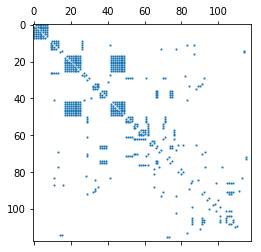

In [5]:
plt.spy(A_inverted, markersize=1)

(array([ 7., 15., 21.,  6., 10.,  9., 12., 18.,  1.,  2.,  0.,  0.,  0.,
         0.,  0., 17.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16.]),
 <a list of 16 Patch objects>)

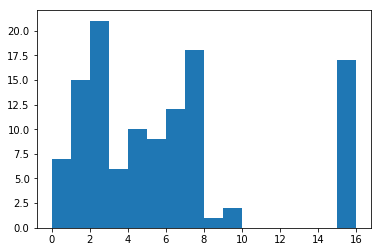

In [9]:
degrees = sum(A_inverted)
plt.hist(degrees, bins=16)

In [17]:
s = 'http://profilesinterror.mindswap.org/document/2005/08/09/16:43:04#_http://counterterror.mindswap.org/2005/terrorists.owl#Mustafa_Kamel'

j = s.split('http://')[1:]

In [23]:
for i in j:
    m, name = i.split('#')
    if len(name) < 2:
        ide = m.split('document')[1]
    else:
        ide = name
    print(ide)


/2005/08/09/16:43:04
Mustafa_Kamel


In [4]:
d = '[aksldfj_akdsjfakf]'

In [6]:
d = d.split(']')[0]
d

'[aksldfj_akdsjfakf'

In [6]:
d = d.replace(']','')

In [7]:
d

'[aksldfj_akdsjfakf'